In [217]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

from sklearn.metrics import mean_absolute_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model  import LinearRegression

In [218]:
df = pd.read_csv('kmf.csv')
df

,from_date,item_descr,amount
0,2016-01-04,Menü 1,60
1,2016-01-04,Menü 2,101
2,2016-01-04,Menü 3,76
3,2016-01-05,Menü 1,52
4,2016-01-05,Menü 2,96
...,...,...,...
3034,2020-03-05,Menü 2,100
3035,2020-03-05,Menü 3,145
3036,2020-03-06,Menü 1,56
3037,2020-03-06,Menü 2,54


In [219]:
df['date'] = pd.to_datetime(df['from_date'])
df.drop(['from_date'], axis = 1, inplace = True)
df['menu'] = df['item_descr'].replace({'Menü 1': '1', 'Menü 2': '2', 'Menü 3': '3'})
df.set_index(df['date'], inplace=True)
df.drop(['date'], axis=1, inplace=True)
df.drop(['item_descr'], axis=1, inplace=True)
df = df.iloc[:, [1,0]]
df

,menu,amount
date,,
2016-01-04,1,60
2016-01-04,2,101
2016-01-04,3,76
2016-01-05,1,52
2016-01-05,2,96
...,...,...
2020-03-05,2,100
2020-03-05,3,145
2020-03-06,1,56


In [220]:
df = df.pivot_table(index='date', columns='menu', values='amount')

In [221]:
s1 = pd.Series(index = df.index, data = df['1'].values).resample('W').sum()
s2 = pd.Series(index = df.index, data = df['2'].values).resample('W').sum()
s3 = pd.Series(index = df.index, data = df['3'].values).resample('W').sum()

Text(0, 0.5, 'Amoumt')

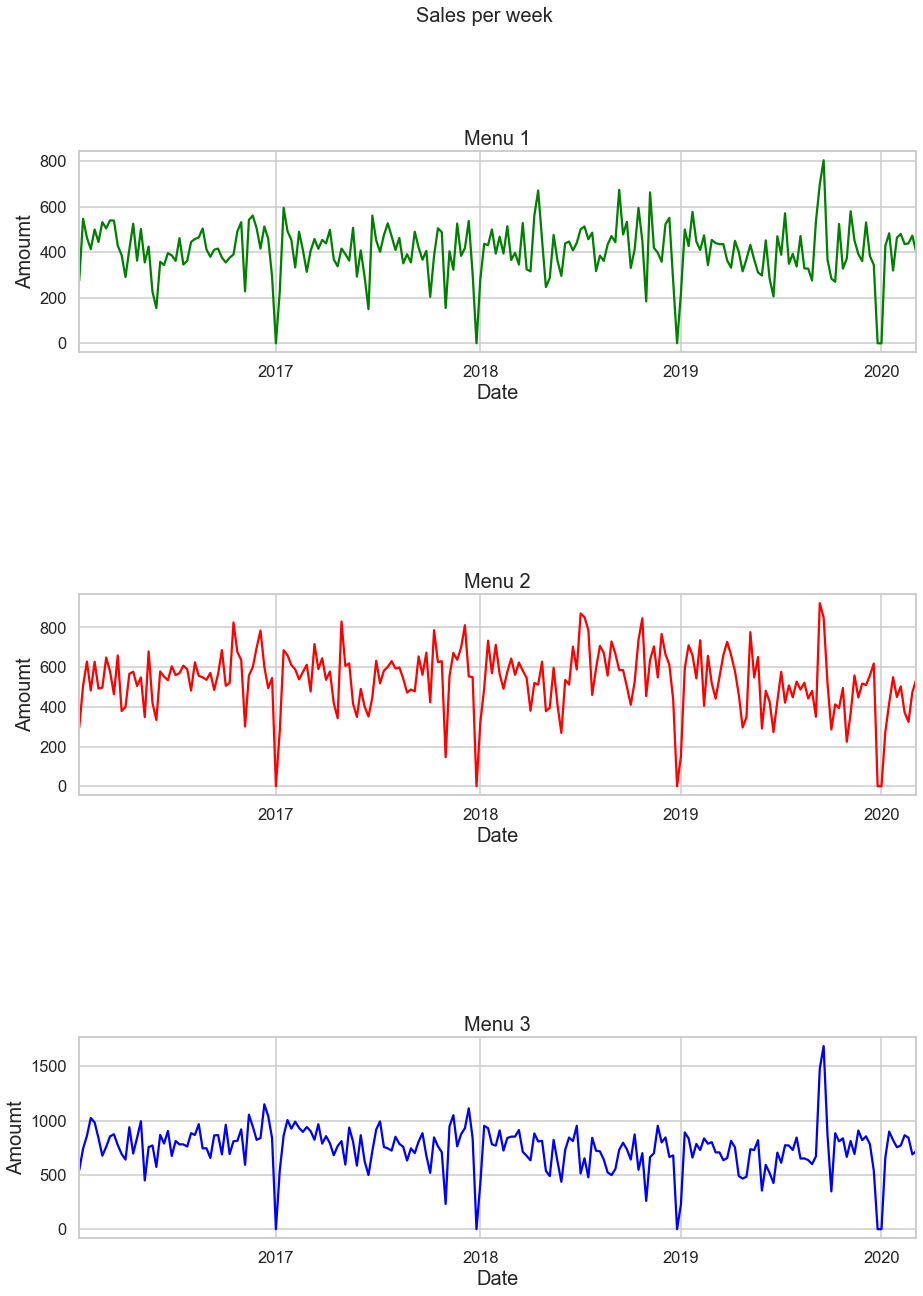

In [222]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 20))
fig.suptitle('Sales per week', fontsize=20)
fig.subplots_adjust(hspace = 1.2)

s1.plot(ax = axes[0], color='green')
axes[0].set_title('Menu 1', fontsize=20)
axes[0].set_xlabel('Date', fontsize=20)
axes[0].set_ylabel('Amoumt', fontsize=20)

s2.plot(ax = axes[1], color='red')
axes[1].set_title('Menu 2', fontsize=20)
axes[1].set_xlabel('Date', fontsize=20)
axes[1].set_ylabel('Amoumt', fontsize=20)

s3.plot(ax = axes[2], color='blue')
axes[2].set_title('Menu 3', fontsize=20)
axes[2].set_xlabel('Date', fontsize=20)
axes[2].set_ylabel('Amoumt', fontsize=20)

In [223]:
def plot_seasonal(trend, seasonal, resid):
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 20))
    fig.suptitle('Seasonal decompose', fontsize=20)
    fig.subplots_adjust(hspace = 1.2)

    trend.plot(ax = axes[0], color='green')
    axes[0].set_title('Trend', fontsize=20)
    axes[0].set_xlabel('Date', fontsize=20)
    axes[0].set_ylabel('Value', fontsize=20)

    seasonal.plot(ax = axes[1], color='red')
    axes[1].set_title('Seasonal', fontsize=20)
    axes[1].set_xlabel('Date', fontsize=20)
    axes[1].set_ylabel('Value', fontsize=20)

    resid.plot(ax = axes[2], color='blue')
    axes[2].set_title('Resuid', fontsize=20)
    axes[2].set_xlabel('Date', fontsize=20)
    axes[2].set_ylabel('Value', fontsize=20)

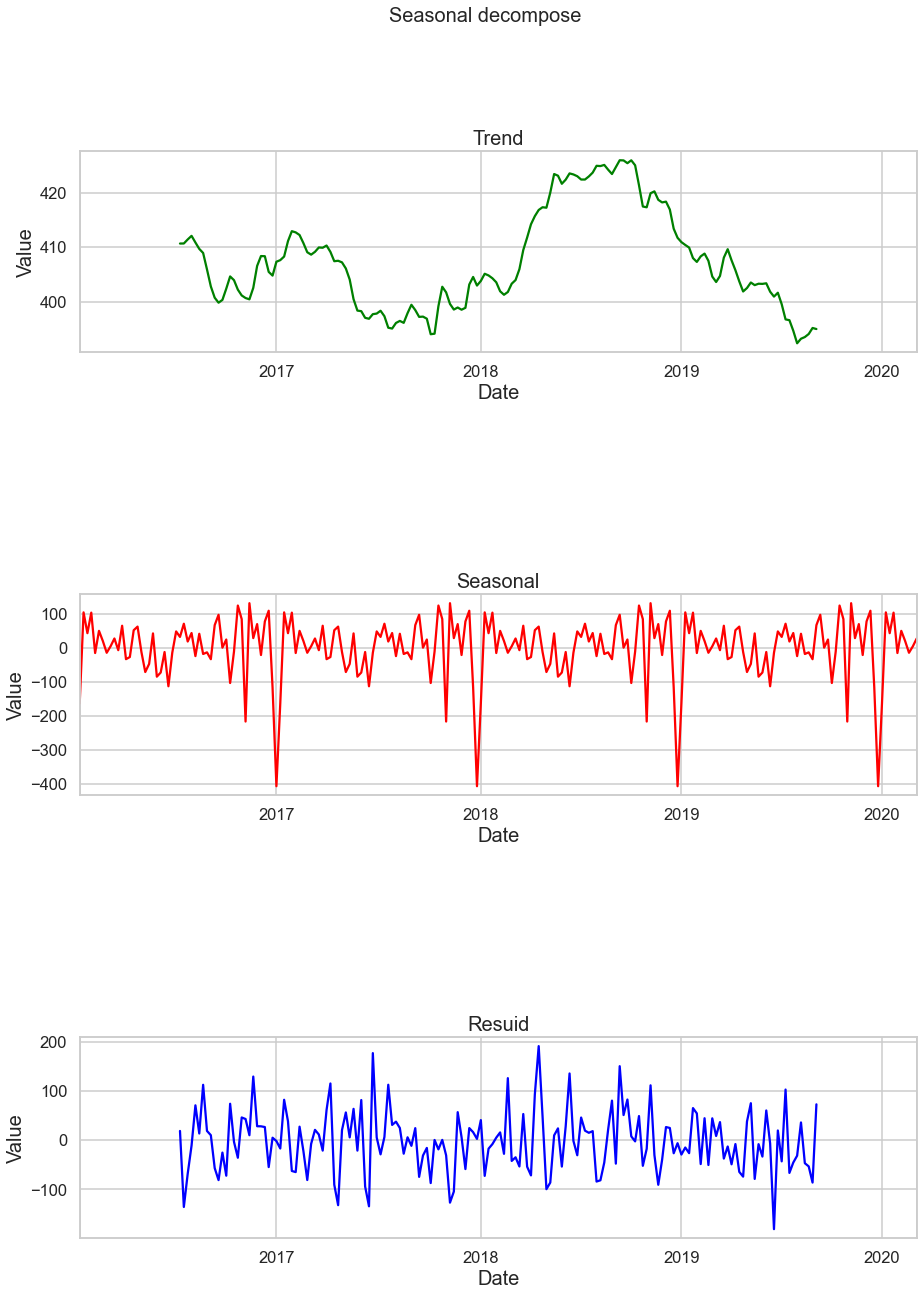

In [224]:
result = seasonal_decompose(s1, model='additive')

plot_seasonal(result.trend, result.seasonal, result.resid)

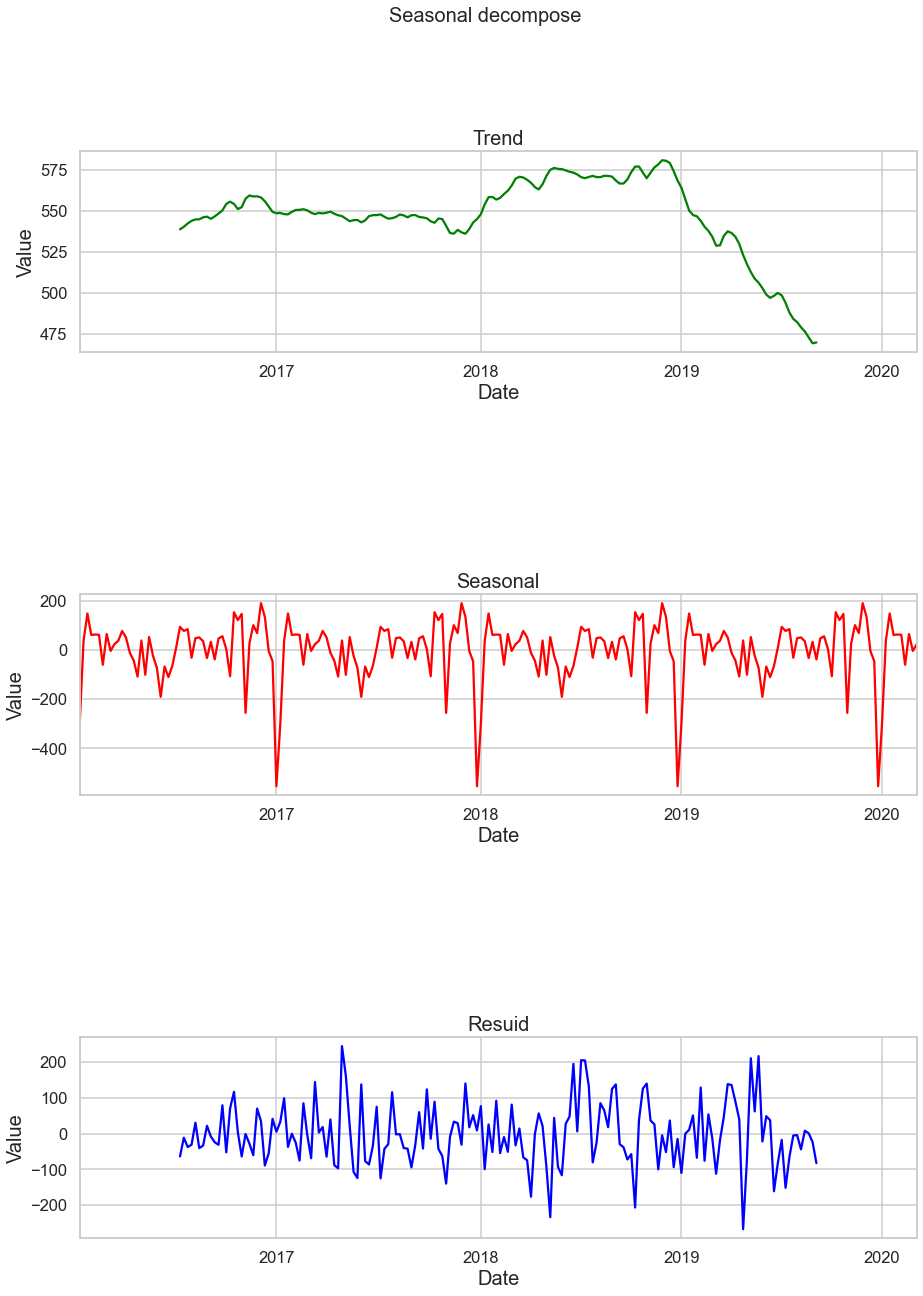

In [225]:
result = seasonal_decompose(s2, model='additive')

plot_seasonal(result.trend, result.seasonal, result.resid)

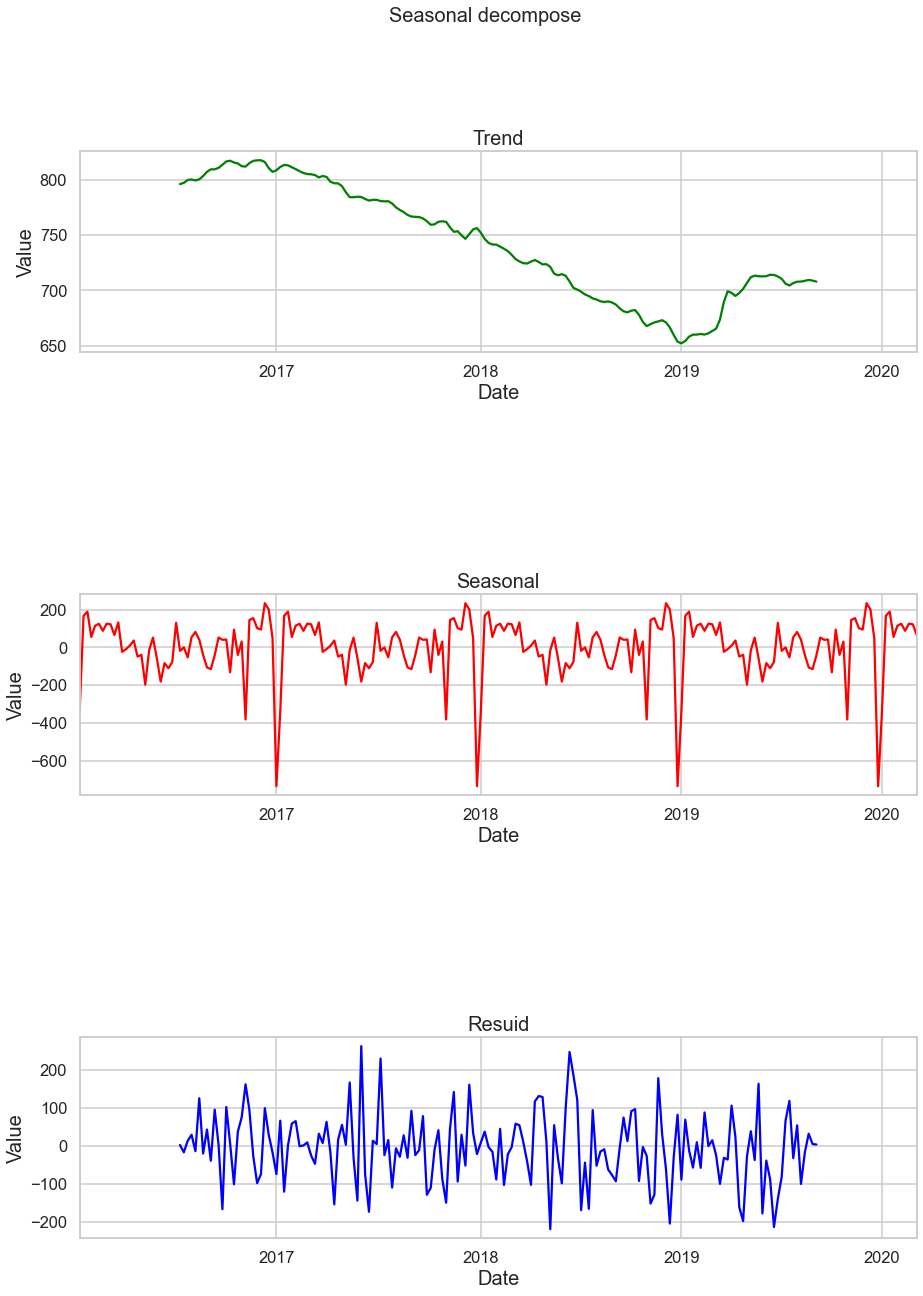

In [226]:
result = seasonal_decompose(s3, model='additive')

plot_seasonal(result.trend, result.seasonal, result.resid)

Text(0, 0.5, 'Amoumt')

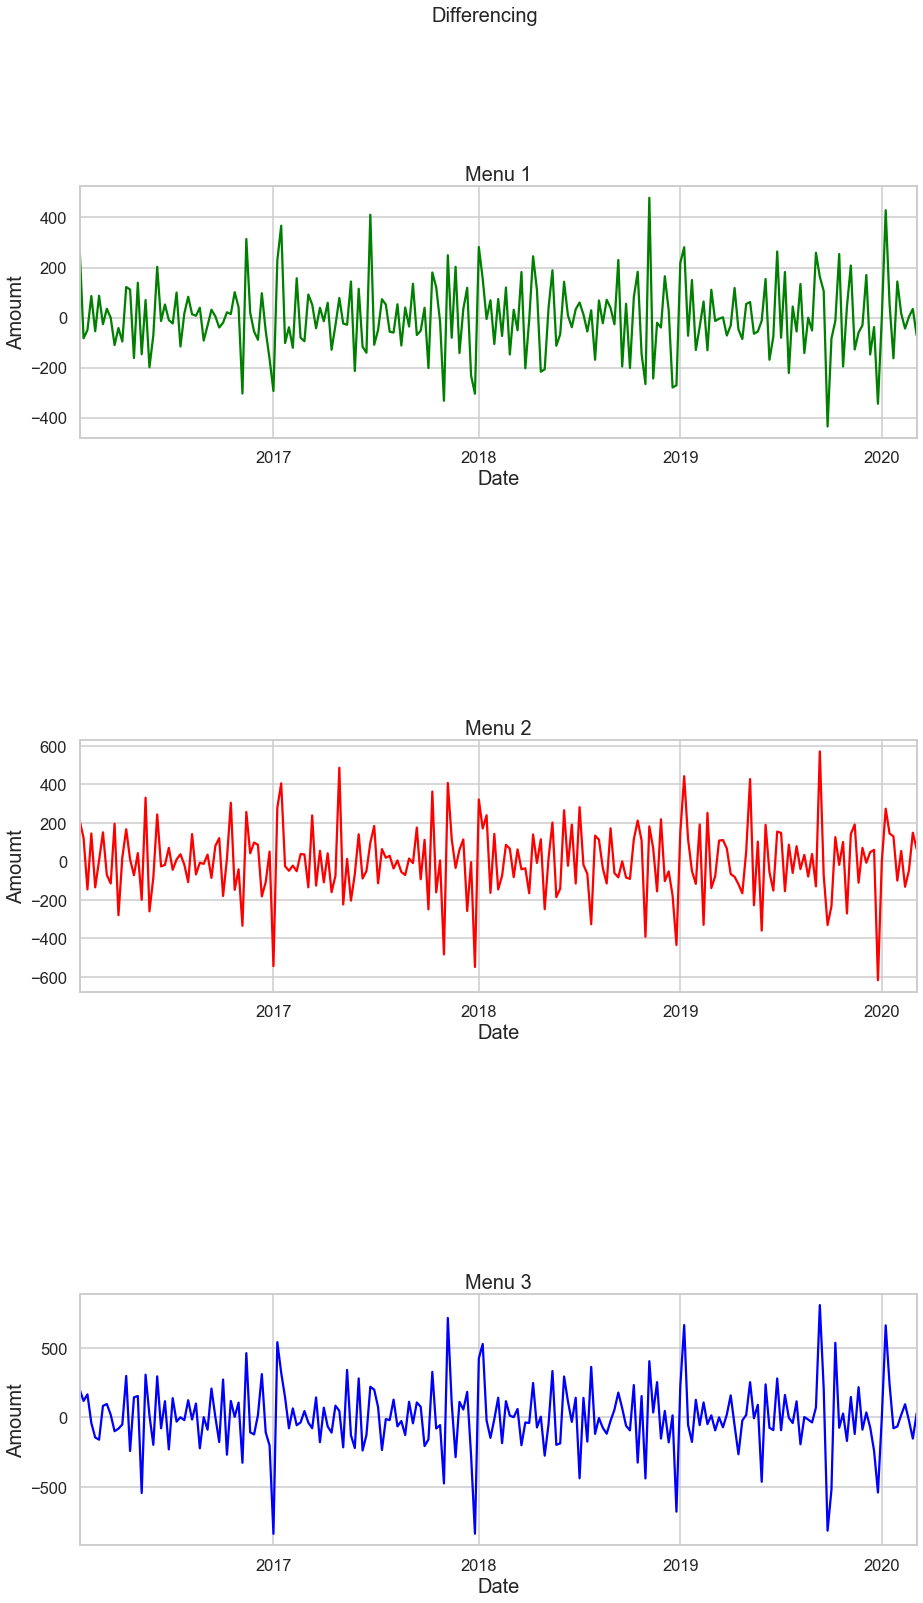

In [227]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 25))
fig.suptitle('Differencing', fontsize=20)
fig.subplots_adjust(hspace = 1.2)

df['1'].resample('W').sum().diff().dropna().plot(ax = axes[0], color='green')
axes[0].set_title('Menu 1', fontsize=20)
axes[0].set_xlabel('Date', fontsize=20)
axes[0].set_ylabel('Amoumt', fontsize=20)

df['2'].resample('W').sum().diff().dropna().plot(ax = axes[1], color='red')
axes[1].set_title('Menu 2', fontsize=20)
axes[1].set_xlabel('Date', fontsize=20)
axes[1].set_ylabel('Amoumt', fontsize=20)

df['3'].resample('W').sum().diff().dropna().plot(ax = axes[2], color='blue')
axes[2].set_title('Menu 3', fontsize=20)
axes[2].set_xlabel('Date', fontsize=20)
axes[2].set_ylabel('Amoumt', fontsize=20)

In [228]:
df['diff1']=df['1'].diff(periods=1)
df['diff2']=df['2'].diff(periods=1)
df['diff3']=df['3'].diff(periods=1)
acf_results1 = acf(df['diff1'],nlags=30,fft=False, missing='drop')
acf_results2 = acf(df['diff2'],nlags=30,fft=False, missing='drop')
acf_results3 = acf(df['diff3'],nlags=30,fft=False, missing='drop')

traces = list()
for i in range(len(acf_results1)):
    traces.append(Scatter(x=[i,i],
                         y = [0,acf_results1[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

In [229]:
traces = list()
for i in range(len(acf_results2)):
    traces.append(Scatter(x=[i,i],
                         y = [0,acf_results2[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

In [230]:
traces = list()
for i in range(len(acf_results3)):
    traces.append(Scatter(x=[i,i],
                         y = [0,acf_results3[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

In [231]:
df.dropna(inplace=True)
pacf_results1 = pacf(df['diff1'],nlags=30, method = 'ols')

df.dropna(inplace=True)
pacf_results2 = pacf(df['diff2'],nlags=30, method = 'ols')

df.dropna(inplace=True)
pacf_results3 = pacf(df['diff3'],nlags=30, method = 'ols')

traces = list()
for i in range(len(pacf_results1)):
    traces.append(Scatter(x=[i,i],
                         y = [0,pacf_results1[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

In [232]:
traces = list()
for i in range(len(pacf_results2)):
    traces.append(Scatter(x=[i,i],
                         y = [0,pacf_results2[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

In [233]:
traces = list()
for i in range(len(pacf_results3)):
    traces.append(Scatter(x=[i,i],
                         y = [0,pacf_results3[i]],
                         showlegend=False,
                         line = {'color':'black'}))
fig = Figure(data=traces)
fig.show()

83 27 108


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 141.54369289048003 r2: -1.1225453827646033


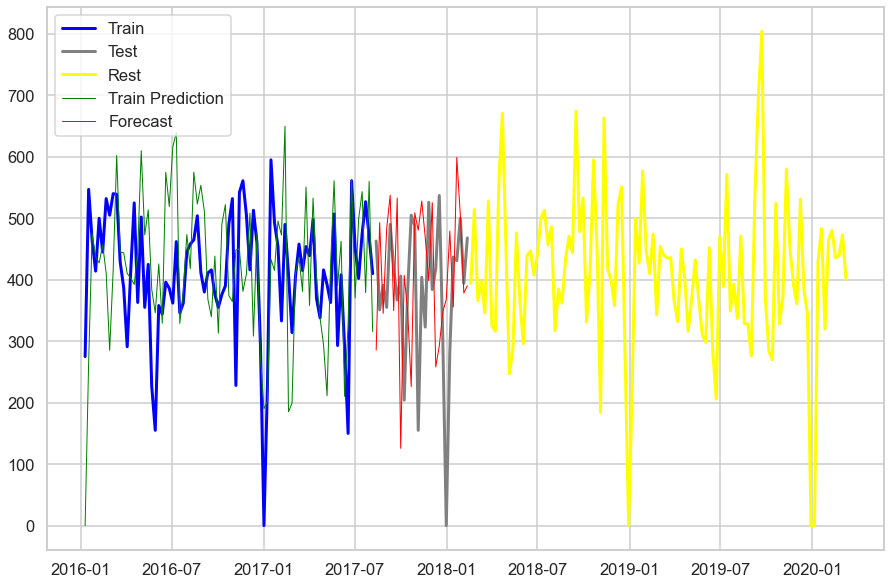

110 27 81


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 91.70062255778747 r2: -0.329559957985027


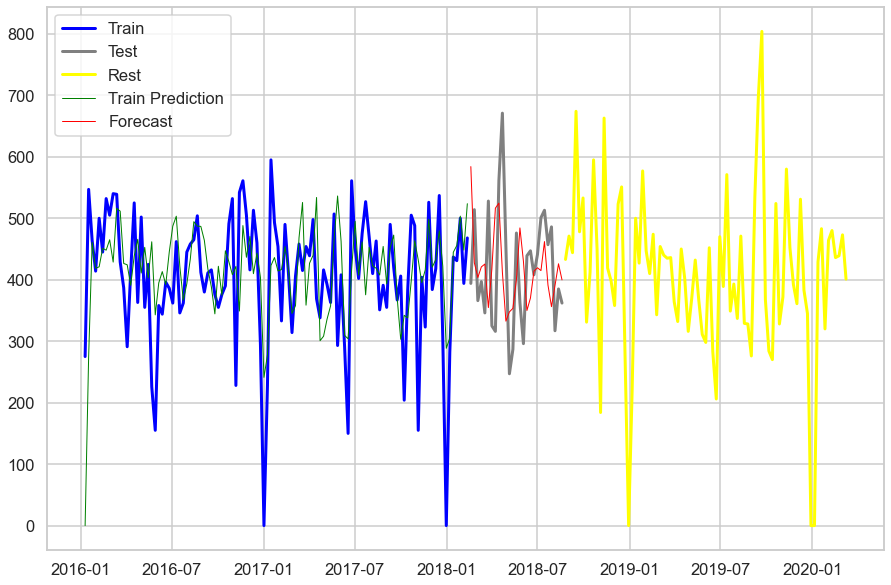

137 27 54


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 118.00727019011855 r2: -0.1677973039736127


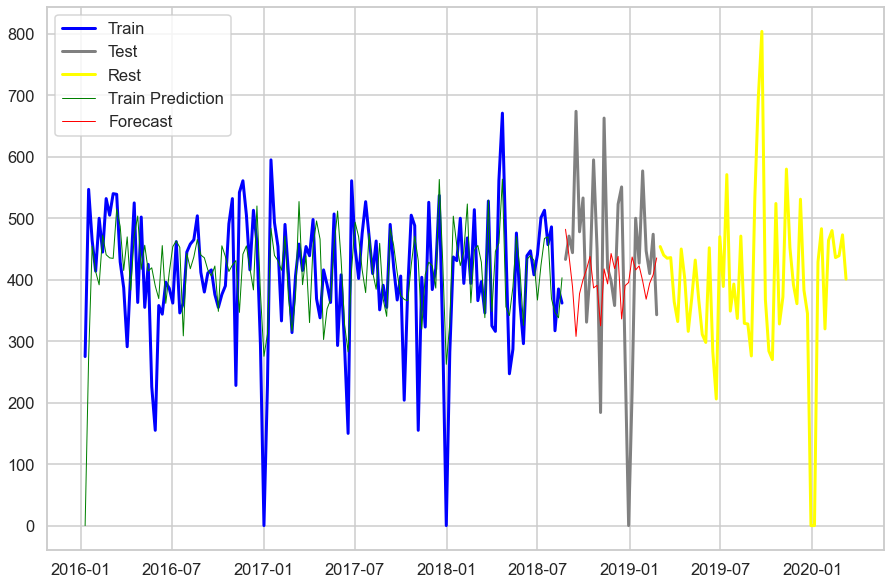

164 27 27


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 69.99631003056192 r2: -0.14746035026176552


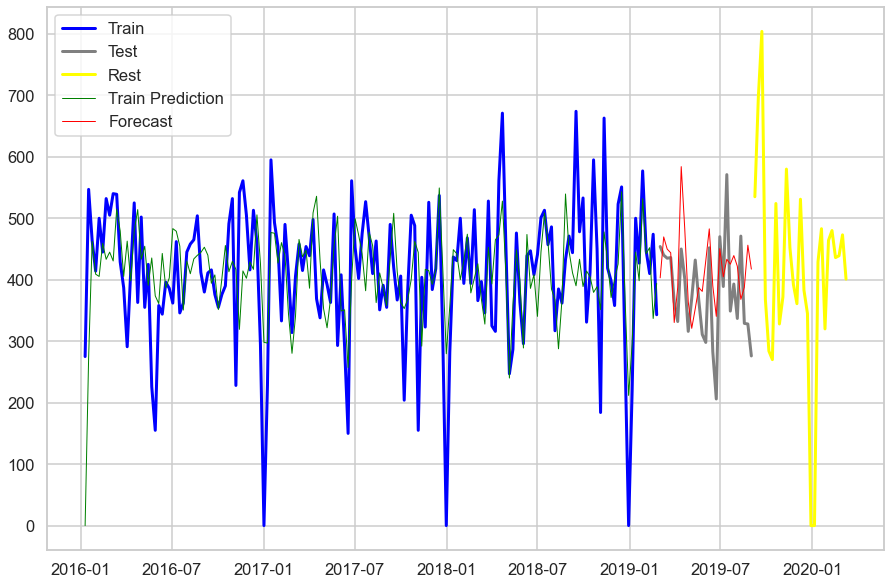

191 27 0


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 102.69017577704753 r2: 0.10385243763346763


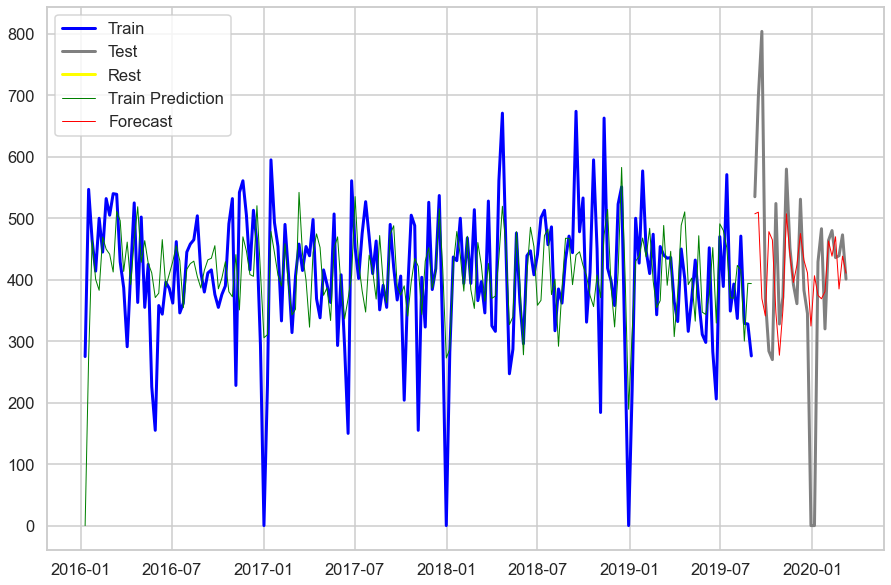

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               ARIMA(10, 1, 20)   Log Likelihood               -1136.254
Date:                Sun, 03 Jul 2022   AIC                           2334.509
Time:                        22:19:23   BIC                           2435.167
Sample:                    01-10-2016   HQIC                          2375.284
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0147      0.554     -1.831      0.067      -2.101       0.071
ar.L2         -0.7676      0.803     -0.956      0.339      -2.341       0.806
ar.L3         -0.9819      0.599     -1.639      0.101      -2.156       0.192
ar.L4         -0.6133      0.411     -1.490      0.136      -1.420       0.193
ar.L5         -0.7054      0.349     -2.019      0.044      -1.390      -0.021
ar.L6         -0.8303      0.497     -1.672      0.094      -1.804       0.143
ar.L7         -1.3483      0.508     -2.655      0.008      -2.343      -0.353
ar.L8         -0.7758      0.683     -1.135      0.256      -2.115       0.564
ar.L9         -0.3663      0.596     -0.615      0.539      -1.535       0.802
ar.L10        -0.4927      0.311     -1.584      0.113      -1.102       0.117
ma.L1          0.2104      1.412      0.149      0.882      -2.556       2.977
ma.L2         -0.2720      2.031     -0.134      0.894      -4.253       3.710
ma.L3          0.1378      1.259      0.109      0.913      -2.330       2.605
ma.L4         -0.3114      2.152     -0.145      0.885      -4.530       3.907
ma.L5          0.0197      1.154      0.017      0.986      -2.241       2.281
ma.L6         -0.0150      1.466     -0.010      0.992      -2.889       2.858
ma.L7          0.5674      1.096      0.518      0.605      -1.581       2.716
ma.L8         -0.1550      2.027     -0.076      0.939      -4.128       3.818
ma.L9         -0.4922      1.497     -0.329      0.742      -3.426       2.441
ma.L10        -0.2340      1.186     -0.197      0.844      -2.558       2.090
ma.L11        -0.5399      1.005     -0.537      0.591      -2.509       1.430
ma.L12        -0.1699      1.315     -0.129      0.897      -2.747       2.408
ma.L13         0.0545      0.545      0.100      0.920      -1.014       1.123
ma.L14         0.2483      1.034      0.240      0.810      -1.779       2.275
ma.L15         0.0949      0.640      0.148      0.882      -1.159       1.349
ma.L16        -0.2556      0.637     -0.401      0.688      -1.503       0.992
ma.L17        -0.2327      0.572     -0.407      0.684      -1.353       0.888
ma.L18         0.1468      0.517      0.284      0.777      -0.867       1.161
ma.L19         0.1595      0.345      0.462      0.644      -0.518       0.837
ma.L20         0.0422      0.256      0.165      0.869      -0.459       0.543
sigma2      9403.0800   1.66e+04      0.566      0.571   -2.32e+04     4.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.16
Prob(Q):                              0.95   Prob(JB):                         0.08
Heteroskedasticity (H):               1.06   Skew:                            -0.29
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

In [234]:
# Model for first Menu

n_splits = 5
test_size = 27
size = len(s1)

for i in reversed(range(n_splits)):
    idx = size - (i + 1) * test_size
    
    train = s1[0:idx]
    test = s1[idx: idx + test_size]
    rest = s1[idx + test_size:]
    
    print(len(train), len(test), len(rest))
    
    model = ARIMA(train, order=(10, 1, 20))
    
    model_fit = model.fit()

    pred_train = model_fit.fittedvalues
    
    pred_test = model_fit.forecast(len(test))
    
    mae = mean_absolute_error(test, pred_test)
    r2 = r2_score(test,pred_test)
    print('mae:', mae, 'r2:', r2)

    fig, ax = plt.subplots()
    ax.plot(train, linewidth = 3, color='blue',label = 'Train')
    ax.plot(test, linewidth = 3, color = 'grey', label ='Test')
    ax.plot(rest, linewidth = 3, color = 'yellow', label ='Rest')
    ax.plot(pred_train, linewidth = 1, color = 'green', label ='Train Prediction')
    ax.plot(pred_test, linewidth = 1, color = 'red', label ='Forecast')
    ax.legend()
    plt.show()

model_fit.summary()

83 27 108


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 161.38201634632628 r2: -0.36946408758742466


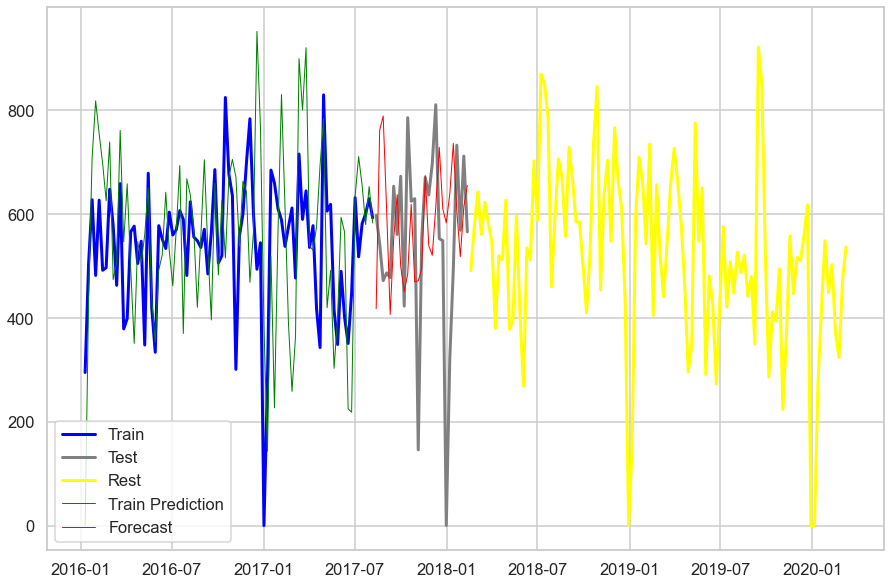

110 27 81


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 117.66751773801512 r2: -0.16173998986839555


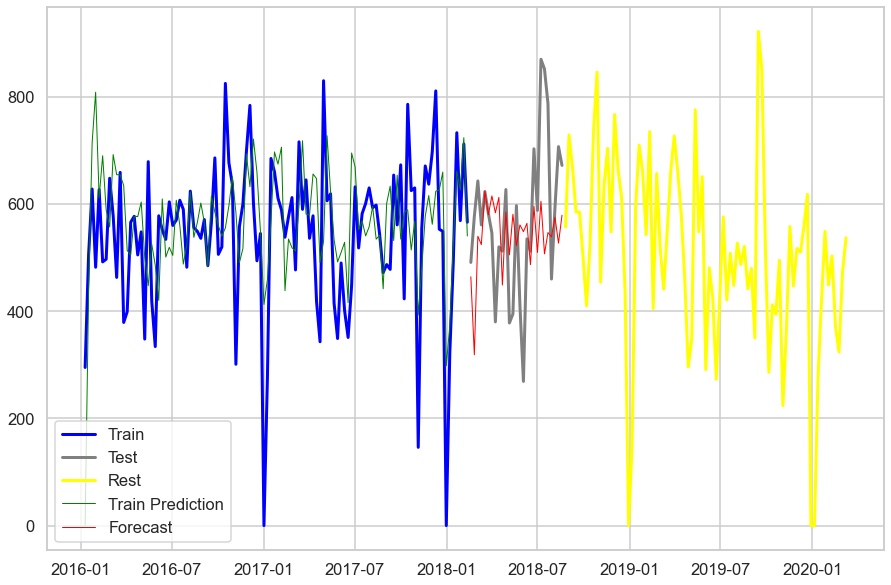

137 27 54


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 131.89089628544266 r2: -0.08524583323612611


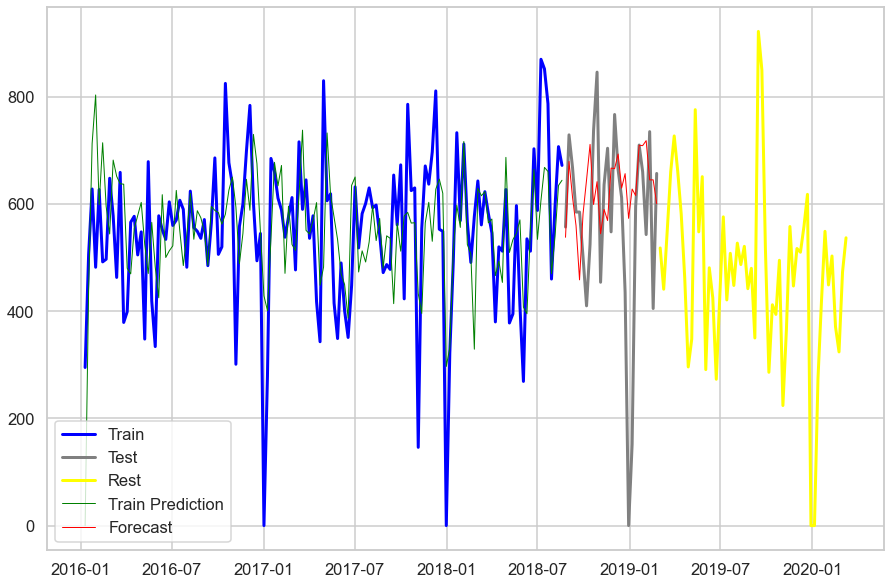

164 27 27


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 144.23219208398058 r2: -0.936468515494866


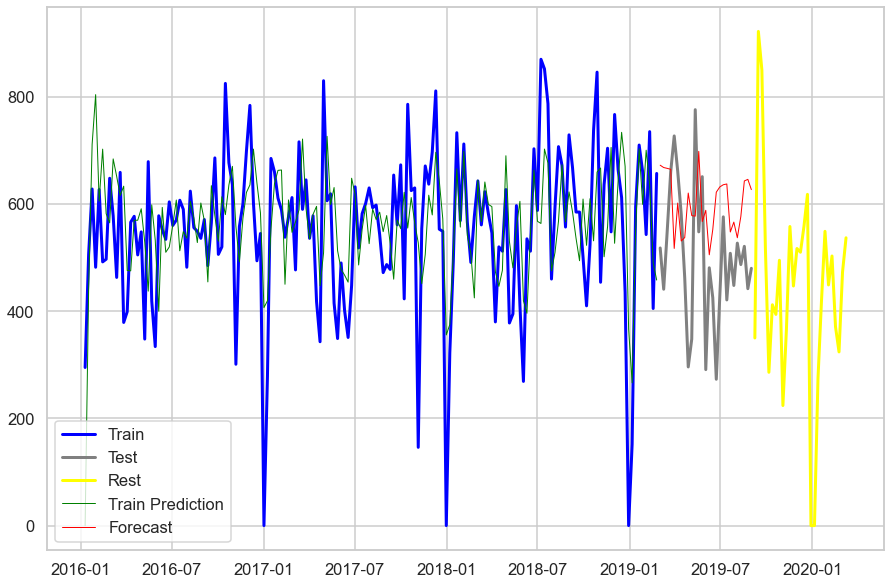

191 27 0


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 137.55958982419673 r2: 0.07394933668158721


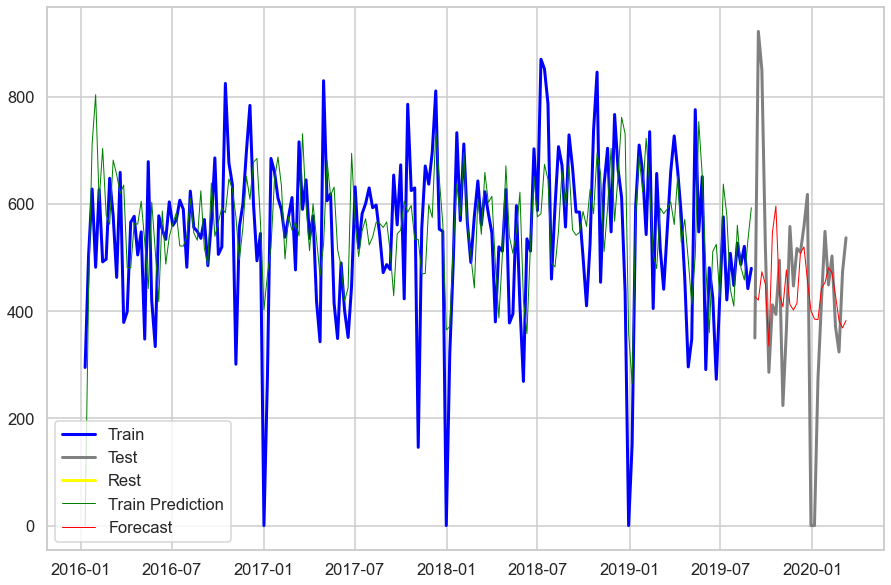

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               ARIMA(10, 2, 20)   Log Likelihood               -1192.779
Date:                Sun, 03 Jul 2022   AIC                           2447.558
Time:                        22:19:40   BIC                           2548.052
Sample:                    01-10-2016   HQIC                          2488.271
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5631      1.679     -0.931      0.352      -4.853       1.727
ar.L2         -2.0357      1.393     -1.461      0.144      -4.766       0.694
ar.L3         -2.6415      2.590     -1.020      0.308      -7.718       2.435
ar.L4         -2.7466      2.671     -1.028      0.304      -7.982       2.489
ar.L5         -2.7660      2.809     -0.985      0.325      -8.272       2.740
ar.L6         -2.5833      2.764     -0.934      0.350      -8.001       2.835
ar.L7         -2.3508      2.511     -0.936      0.349      -7.271       2.570
ar.L8         -1.4294      2.295     -0.623      0.533      -5.928       3.069
ar.L9         -0.7931      0.988     -0.803      0.422      -2.729       1.143
ar.L10        -0.3649      0.837     -0.436      0.663      -2.005       1.275
ma.L1         -0.1154      1.696     -0.068      0.946      -3.439       3.208
ma.L2          0.0129      1.604      0.008      0.994      -3.130       3.156
ma.L3          0.0329      1.434      0.023      0.982      -2.777       2.843
ma.L4         -0.5179      1.196     -0.433      0.665      -2.862       1.826
ma.L5         -0.2015      0.433     -0.466      0.641      -1.049       0.646
ma.L6         -0.2962      0.486     -0.610      0.542      -1.248       0.656
ma.L7         -0.2470      0.473     -0.522      0.602      -1.174       0.680
ma.L8         -0.5075      0.408     -1.243      0.214      -1.308       0.293
ma.L9          0.1473      0.671      0.220      0.826      -1.168       1.462
ma.L10         0.0111      0.743      0.015      0.988      -1.445       1.468
ma.L11         0.1638      0.613      0.267      0.789      -1.037       1.365
ma.L12         0.6276      0.866      0.725      0.469      -1.070       2.325
ma.L13         0.0158      0.508      0.031      0.975      -0.981       1.012
ma.L14        -0.0248      0.336     -0.074      0.941      -0.684       0.634
ma.L15         0.2140      0.366      0.585      0.559      -0.503       0.931
ma.L16        -0.2038      0.237     -0.862      0.389      -0.668       0.260
ma.L17        -0.1554      0.550     -0.283      0.777      -1.233       0.922
ma.L18         0.2440      0.293      0.833      0.405      -0.330       0.818
ma.L19         0.0121      0.325      0.037      0.970      -0.625       0.649
ma.L20        -0.1761      0.333     -0.529      0.597      -0.829       0.477
sigma2      1.932e+04   6224.964      3.104      0.002    7121.697    3.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.58
Prob(Q):                              0.99   Prob(JB):                         0.10
Heteroskedasticity (H):               1.42   Skew:                            -0.31
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

In [235]:
# Model for second Menu

n_splits = 5
test_size = 27
size = len(s2)

for i in reversed(range(n_splits)):
    idx = size - (i + 1) * test_size
    
    train = s2[0:idx]
    test = s2[idx: idx + test_size]
    rest = s2[idx + test_size:]
    
    print(len(train), len(test), len(rest))
    
    model = ARIMA(train, order=(10, 2, 20))
    
    model_fit = model.fit()

    pred_train = model_fit.fittedvalues
    
    pred_test = model_fit.forecast(len(test))
    
    mae = mean_absolute_error(test, pred_test)
    r2 = r2_score(test,pred_test)
    print('mae:', mae, 'r2:', r2)

    fig, ax = plt.subplots()
    ax.plot(train, linewidth = 3, color='blue',label = 'Train')
    ax.plot(test, linewidth = 3, color = 'grey', label ='Test')
    ax.plot(rest, linewidth = 3, color = 'yellow', label ='Rest')
    ax.plot(pred_train, linewidth = 1, color = 'green', label ='Train Prediction')
    ax.plot(pred_test, linewidth = 1, color = 'red', label ='Forecast')
    ax.legend()
    plt.show()

model_fit.summary()

83 27 108


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 287.073964997118 r2: -1.1409416164390085


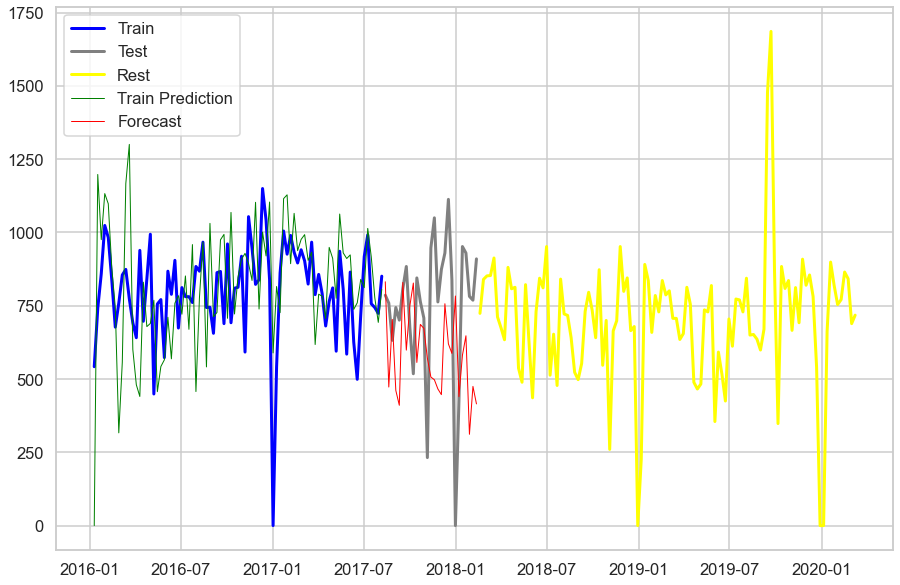

110 27 81


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 134.75055609731655 r2: -0.27533035651973226


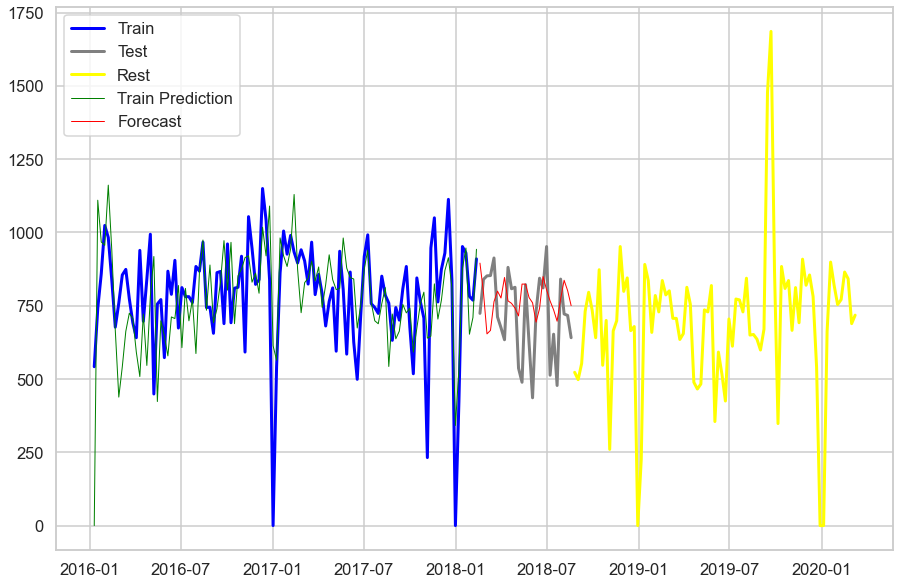

137 27 54


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 179.76500591906498 r2: -0.06755864991380145


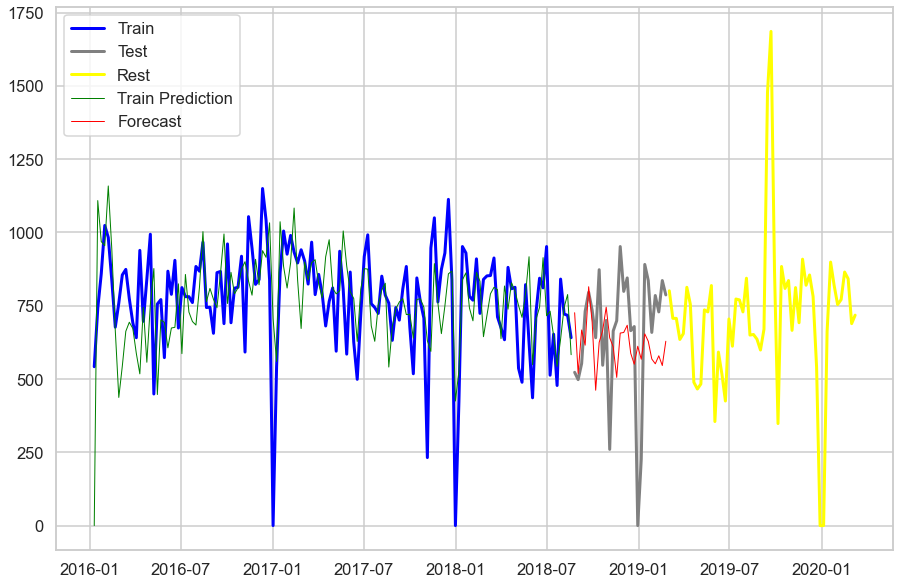

164 27 27


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 114.83283241181431 r2: -0.4440756399027521


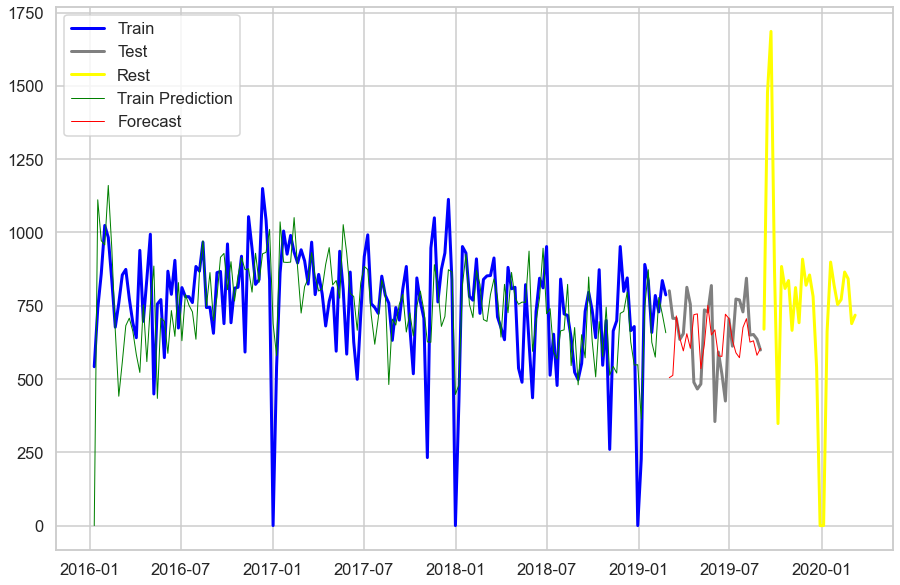

191 27 0


/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/aleksandrvolkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



mae: 218.05679961418005 r2: 0.02588450140625942


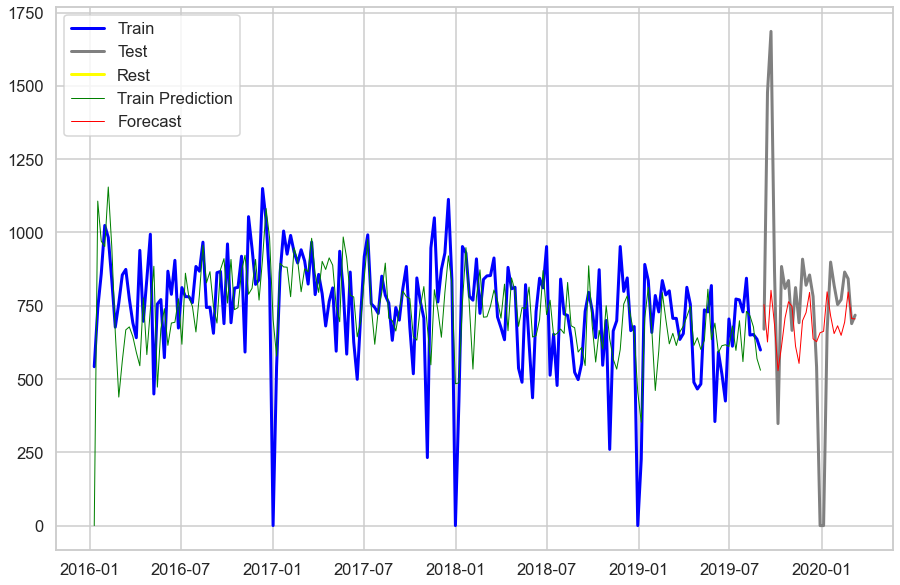

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               ARIMA(10, 3, 17)   Log Likelihood               -1233.932
Date:                Sun, 03 Jul 2022   AIC                           2523.864
Time:                        22:19:54   BIC                           2614.484
Sample:                    01-10-2016   HQIC                          2560.580
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7213      0.239    -11.405      0.000      -3.189      -2.254
ar.L2         -4.8152      0.619     -7.782      0.000      -6.028      -3.603
ar.L3         -6.7402      1.024     -6.581      0.000      -8.748      -4.733
ar.L4         -8.4378      1.360     -6.203      0.000     -11.104      -5.772
ar.L5         -9.0149      1.577     -5.717      0.000     -12.105      -5.924
ar.L6         -8.0552      1.581     -5.096      0.000     -11.153      -4.957
ar.L7         -6.0784      1.328     -4.579      0.000      -8.680      -3.476
ar.L8         -4.0159      0.970     -4.141      0.000      -5.917      -2.115
ar.L9         -2.1368      0.550     -3.884      0.000      -3.215      -1.058
ar.L10        -0.7297      0.202     -3.609      0.000      -1.126      -0.333
ma.L1          0.1003      2.232      0.045      0.964      -4.275       4.475
ma.L2         -0.3687      0.812     -0.454      0.650      -1.960       1.223
ma.L3         -0.6720      2.413     -0.278      0.781      -5.402       4.058
ma.L4         -0.1749      1.105     -0.158      0.874      -2.341       1.991
ma.L5         -0.8904      1.336     -0.667      0.505      -3.508       1.728
ma.L6         -0.8014      1.669     -0.480      0.631      -4.073       2.471
ma.L7          0.1417      1.052      0.135      0.893      -1.920       2.203
ma.L8          1.2968      1.416      0.916      0.360      -1.478       4.072
ma.L9          0.6672      2.775      0.240      0.810      -4.772       6.106
ma.L10         0.3611      1.267      0.285      0.776      -2.121       2.843
ma.L11         0.0104      1.247      0.008      0.993      -2.433       2.454
ma.L12         0.2999      2.107      0.142      0.887      -3.829       4.429
ma.L13        -0.6676      1.435     -0.465      0.642      -3.479       2.144
ma.L14        -0.3938      0.670     -0.588      0.556      -1.706       0.919
ma.L15        -0.1226      0.532     -0.231      0.818      -1.165       0.920
ma.L16         0.0714      0.234      0.305      0.760      -0.387       0.530
ma.L17         0.1488      0.481      0.309      0.757      -0.794       1.092
sigma2      2.892e+04    8.1e+04      0.357      0.721    -1.3e+05    1.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.80
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+14. Standard errors may be unstable.
"""

In [236]:
# Model for third Menu

n_splits = 5
test_size = 27
size = len(s3)

for i in reversed(range(n_splits)):
    idx = size - (i + 1) * test_size
    
    train = s3[0:idx]
    test = s3[idx: idx + test_size]
    rest = s3[idx + test_size:]
    
    print(len(train), len(test), len(rest))
    
    model = ARIMA(train, order=(10, 3, 17))
    
    model_fit = model.fit()

    pred_train = model_fit.fittedvalues
    
    pred_test = model_fit.forecast(len(test))
    
    mae = mean_absolute_error(test, pred_test)
    r2 = r2_score(test,pred_test)
    print('mae:', mae, 'r2:', r2)

    fig, ax = plt.subplots()
    ax.plot(train, linewidth = 3, color='blue',label = 'Train')
    ax.plot(test, linewidth = 3, color = 'grey', label ='Test')
    ax.plot(rest, linewidth = 3, color = 'yellow', label ='Rest')
    ax.plot(pred_train, linewidth = 1, color = 'green', label ='Train Prediction')
    ax.plot(pred_test, linewidth = 1, color = 'red', label ='Forecast')
    ax.legend()
    plt.show()

model_fit.summary()

In [240]:
df.resample('W').sum()

menu,1,2,3,diff1,diff2,diff3
date,,,,,,
2016-01-10,215,194,466,31.0,-51.0,69.0
2016-01-17,547,506,741,33.0,15.0,-6.0
2016-01-24,464,628,859,-17.0,15.0,31.0
2016-01-31,414,482,1024,33.0,11.0,-38.0
2016-02-07,500,627,983,-5.0,-16.0,28.0
...,...,...,...,...,...,...
2020-02-09,480,503,771,42.0,3.0,13.0
2020-02-16,436,371,865,-58.0,76.0,-59.0
2020-02-23,439,324,842,2.0,-78.0,59.0


In [249]:
df1 = df.copy()

In [250]:
df1.drop('diff1', axis = 1, inplace=True)
df1.drop('diff2', axis = 1, inplace=True)
df1.drop('diff3', axis = 1, inplace=True)

In [251]:
df1

menu,1,2,3
date,,,
2016-01-05,52,96,102
2016-01-07,72,48,219
2016-01-08,91,50,145
2016-01-11,154,78,157
2016-01-12,149,135,116
...,...,...,...
2020-03-02,70,133,146
2020-03-03,103,165,113
2020-03-04,73,85,220


In [252]:
df1 = df1.resample('W').sum()
df1['shift_1'] = df1['1'].shift(10)
df1.dropna(inplace=True)
df1

menu,1,2,3,shift_1
date,,,,
2016-03-20,429,659,774,215.0
2016-03-27,387,379,692,547.0
2016-04-03,291,399,641,464.0
2016-04-10,413,566,939,414.0
2016-04-17,525,577,697,500.0
...,...,...,...,...
2020-02-09,480,503,771,361.0
2020-02-16,436,371,865,531.0
2020-02-23,439,324,842,383.0


98 22 88
mae: 218.05679961418005 r2: 0.02588450140625942


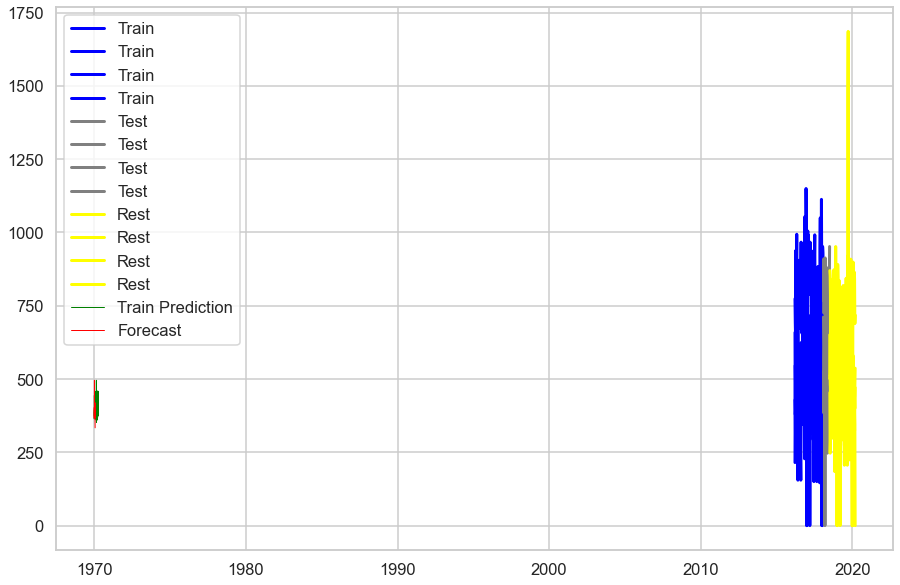

120 22 66
mae: 218.05679961418005 r2: 0.02588450140625942


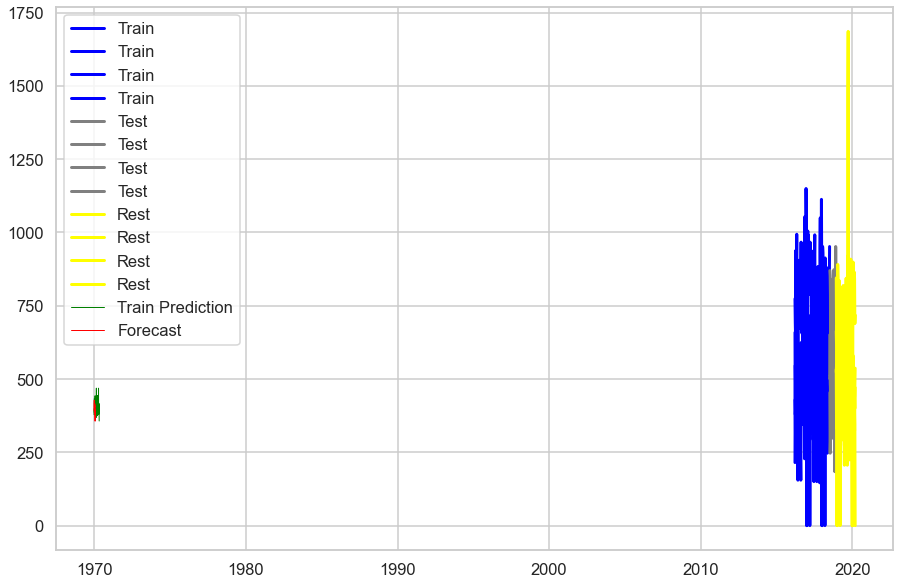

142 22 44
mae: 218.05679961418005 r2: 0.02588450140625942


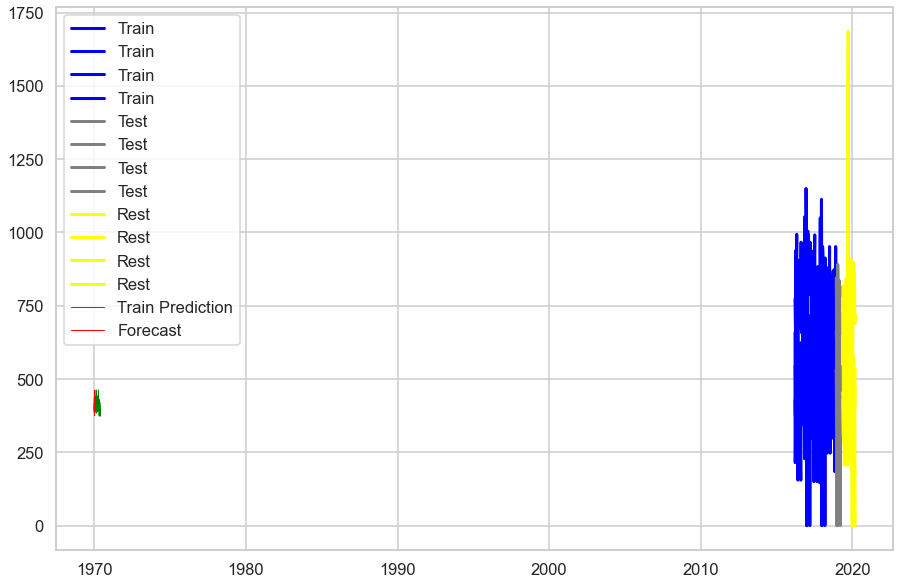

164 22 22
mae: 218.05679961418005 r2: 0.02588450140625942


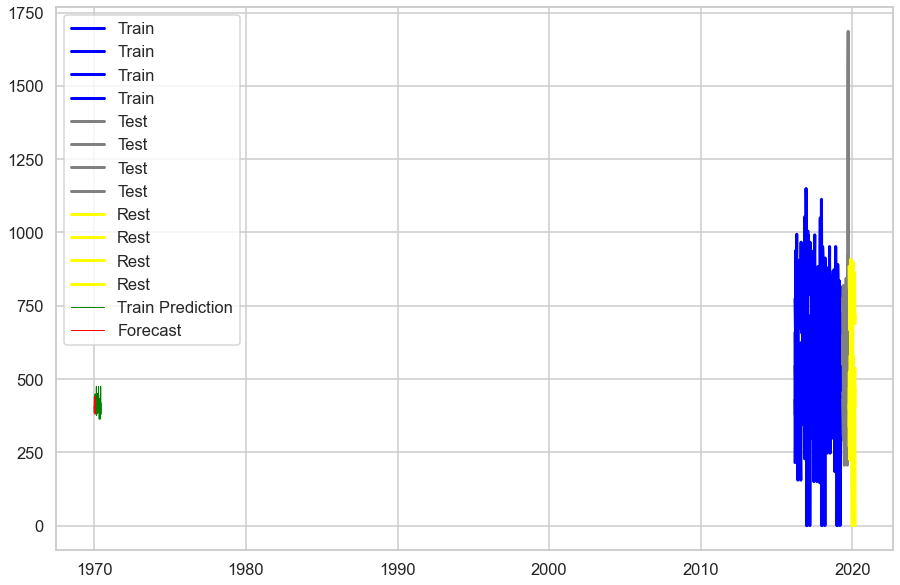

186 22 0
mae: 218.05679961418005 r2: 0.02588450140625942


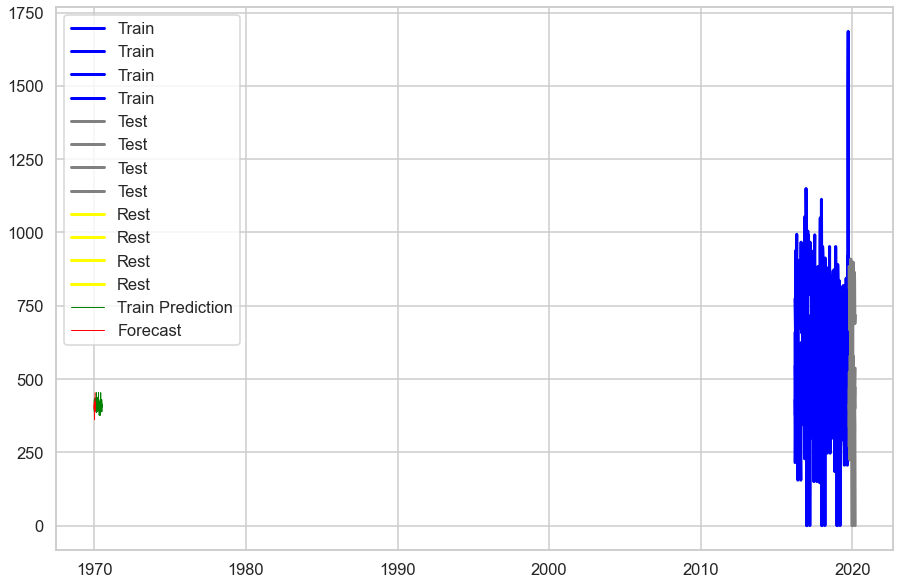

In [253]:
n_splits = 5
test_size = 22
size = len(df1)

for i in reversed(range(n_splits)):
    idx = size - (i + 1) * test_size
    
    train = df1[0:idx]
    test = df1[idx: idx + test_size]
    rest = df1[idx + test_size:]
    
    print(len(train), len(test), len(rest))
    
    model = LinearRegression()
    
    model_fit = model.fit(pd.DataFrame(train['shift_1']), train['1'])

    pred_train = model_fit.predict(pd.DataFrame(train['shift_1']))
    
    pred_test = model_fit.predict(pd.DataFrame(test['shift_1']))

    print('mae:', mae, 'r2:', r2)

    fig, ax = plt.subplots()
    ax.plot(train, linewidth = 3, color='blue',label = 'Train')
    ax.plot(test, linewidth = 3, color = 'grey', label ='Test')
    ax.plot(rest, linewidth = 3, color = 'yellow', label ='Rest')
    ax.plot(pred_train, linewidth = 1, color = 'green', label ='Train Prediction')
    ax.plot(pred_test, linewidth = 1, color = 'red', label ='Forecast')
    ax.legend()
    plt.show()